      Date  Production
0  1962-01         589
1  1962-02         561
2  1962-03         640
3  1962-04         656
4  1962-05         727


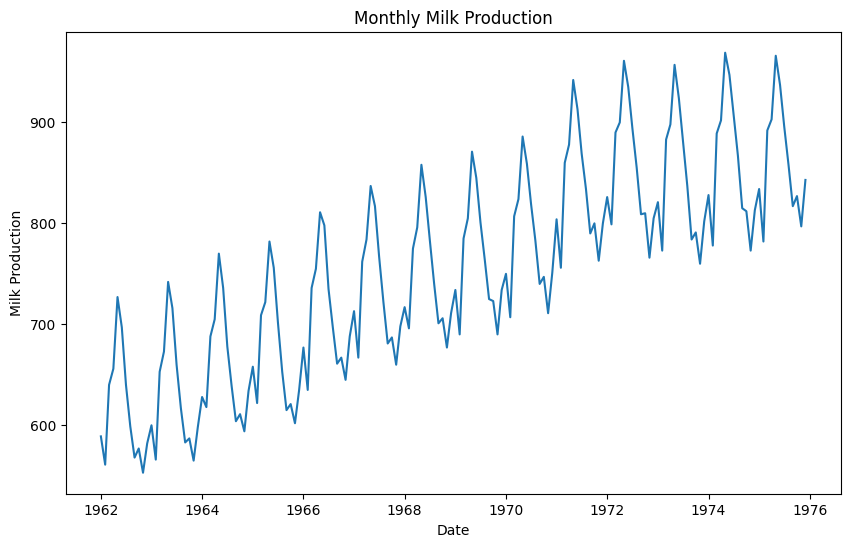

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv('monthly_milk_production.csv')

# Display the first few rows of the dataset
print(data.head())

# Extract the relevant column (assuming production is the second column)
data['Date'] = pd.to_datetime(data['Date'])  # Convert date to datetime
data.set_index('Date', inplace=True)
milk_production = data['Production']

# Plot the data to visualize the trend
plt.figure(figsize=(10,6))
plt.plot(milk_production)
plt.title('Monthly Milk Production')
plt.xlabel('Date')
plt.ylabel('Milk Production')
plt.show()


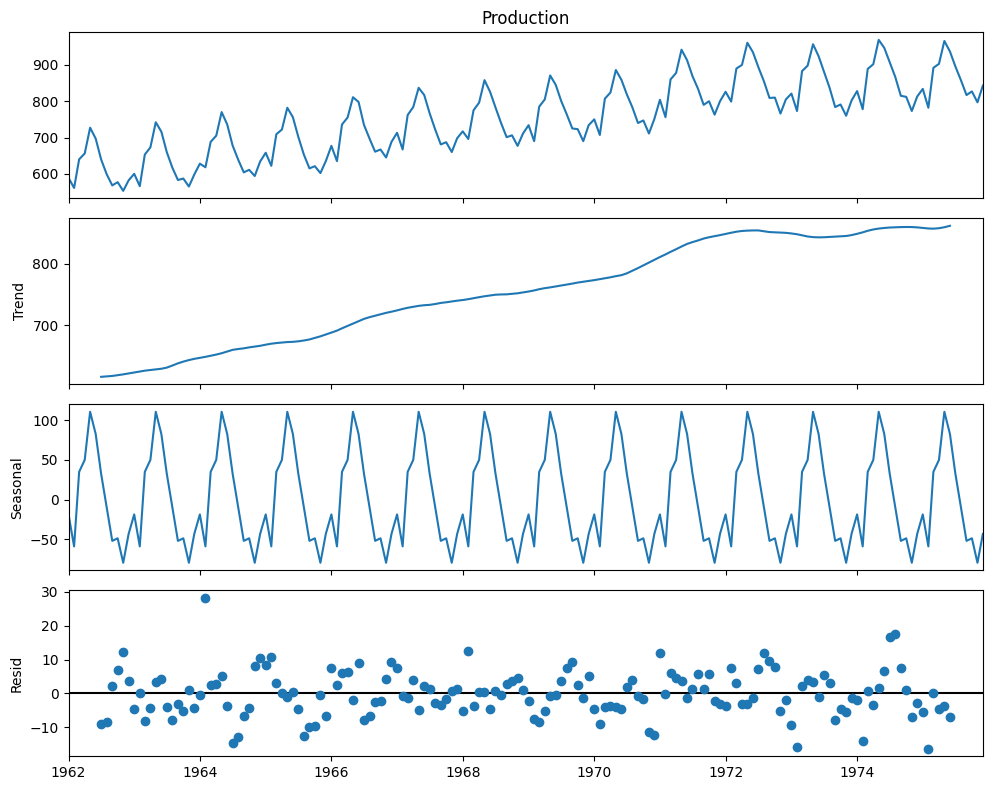

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition (using additive model)
decomposition = seasonal_decompose(milk_production, model='additive', period=12)  # Assuming monthly data

# Plot the decomposition
plt.rcParams.update({'figure.figsize': (10, 8)})
decomposition.plot()
plt.show()


In [2]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(milk_production)

# Print the test statistics
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# Interpret the result
if adf_result[1] < 0.05:
    print("The data is stationary (reject the null hypothesis).")
else:
    print("The data is non-stationary (fail to reject the null hypothesis).")


ADF Statistic: -1.3038115874221345
p-value: 0.6274267086030293
The data is non-stationary (fail to reject the null hypothesis).


In [3]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform Ljung-Box test
ljung_box_result = acorr_ljungbox(milk_production, lags=[10], return_df=True)

print(ljung_box_result)

# Interpret the result
if ljung_box_result['lb_pvalue'].values[0] < 0.05:
    print("The data is not white noise (reject the null hypothesis).")
else:
    print("The data is white noise (fail to reject the null hypothesis).")


      lb_stat      lb_pvalue
10  614.26853  1.541912e-125
The data is not white noise (reject the null hypothesis).


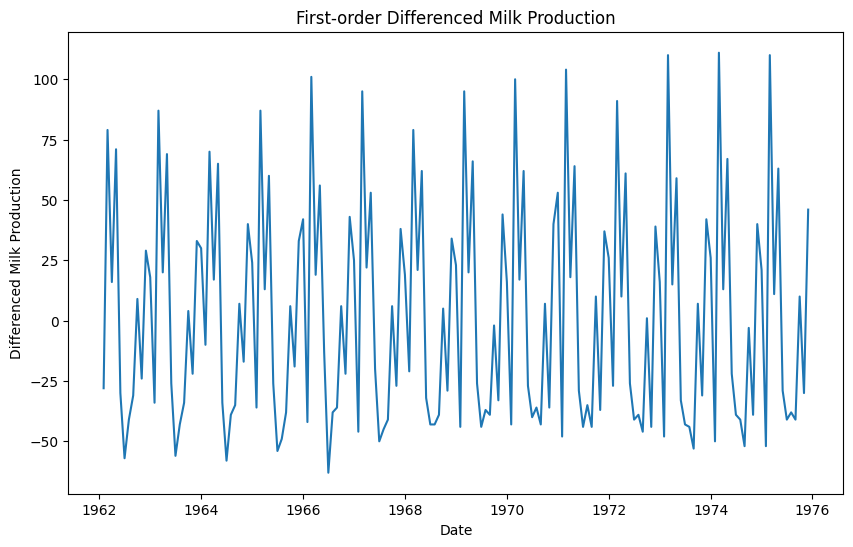

In [4]:
# First-order differencing
milk_production_diff = milk_production.diff().dropna()

# Plot the differenced data
plt.figure(figsize=(10,6))
plt.plot(milk_production_diff)
plt.title('First-order Differenced Milk Production')
plt.xlabel('Date')
plt.ylabel('Differenced Milk Production')
plt.show()


In [5]:
# Perform ADF test on differenced data
adf_result_diff = adfuller(milk_production_diff)

# Print ADF test statistics
print(f'ADF Statistic (After Differencing): {adf_result_diff[0]}')
print(f'p-value: {adf_result_diff[1]}')

# Interpret the result
if adf_result_diff[1] < 0.05:
    print("The differenced data is now stationary (reject the null hypothesis).")
else:
    print("The differenced data is still non-stationary (fail to reject the null hypothesis).")


ADF Statistic (After Differencing): -3.0549955586530833
p-value: 0.030068004001784585
The differenced data is now stationary (reject the null hypothesis).


In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize the differenced data
scaler = MinMaxScaler(feature_range=(0, 1))
milk_production_diff_scaled = scaler.fit_transform(milk_production_diff.values.reshape(-1, 1))

# Create sequences of time steps for LSTM
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define time steps (lag)
time_step = 12  # Considering 12 months as input for predicting the next one

# Create X (features) and y (target)
X, y = create_sequences(milk_production_diff_scaled, time_step)

# Reshape X to be in [samples, time steps, features] format, as required by LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))


In [9]:
# Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\aditya\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test))


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.1865 - val_loss: 0.1309
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1394 - val_loss: 0.0915
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0991 - val_loss: 0.0752
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0770 - val_loss: 0.0883
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0783 - val_loss: 0.0993
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0858 - val_loss: 0.0922
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0786 - val_loss: 0.0807
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0724 - val_loss: 0.0759
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0696 - val_loss: 0.0754
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0722 - val_loss: 0.0761
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0698 - val_loss: 0.0760
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0725 - val_loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


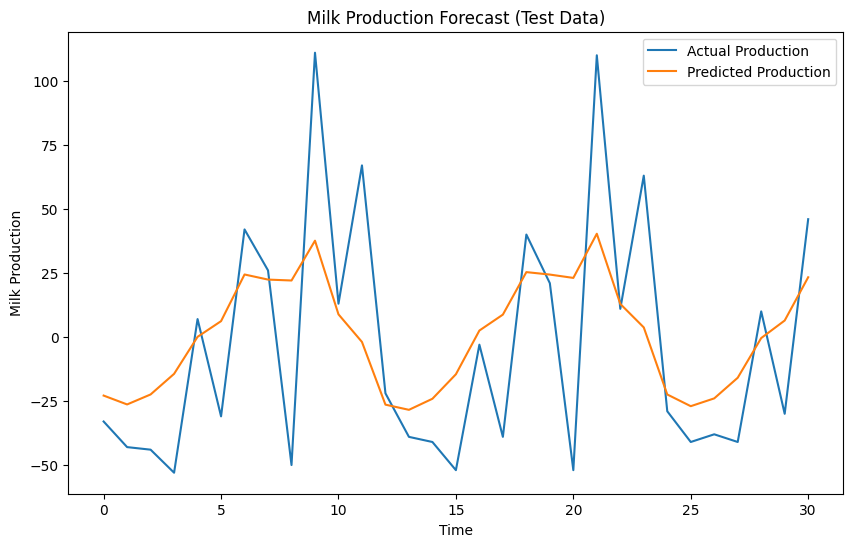

In [12]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Invert the scaling (to get predictions in original scale)
y_pred_inverted = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(y_test_inverted, label='Actual Production')
plt.plot(y_pred_inverted, label='Predicted Production')
plt.title('Milk Production Forecast (Test Data)')
plt.xlabel('Time')
plt.ylabel('Milk Production')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


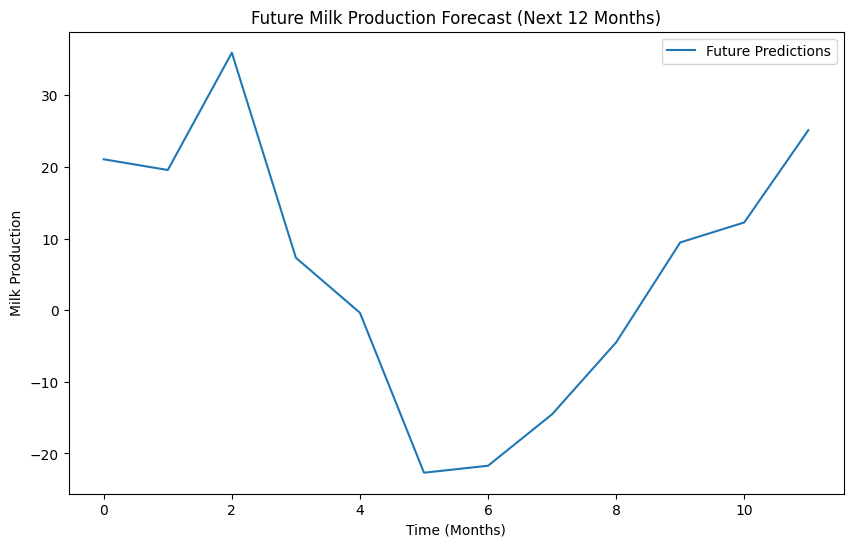

In [14]:
# Use the last 'time_step' data points from the test set to predict future values
last_sequence = milk_production_diff_scaled[-time_step:].reshape(1, time_step, 1)
future_predictions = []

# Predict the next 12 months
for i in range(12):
    # Predict the next value
    next_value = model.predict(last_sequence)
    
    # Append the predicted value to the future_predictions list
    future_predictions.append(next_value[0, 0])
    
    # Update last_sequence by removing the first value and appending the predicted value
    last_sequence = np.append(last_sequence[:, 1:, :], [[[next_value[0, 0]]]], axis=1)  # Reshape and append properly

# Invert the normalization for future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot the future predictions
plt.figure(figsize=(10,6))
plt.plot(future_predictions, label='Future Predictions')
plt.title('Future Milk Production Forecast (Next 12 Months)')
plt.xlabel('Time (Months)')
plt.ylabel('Milk Production')
plt.legend()
plt.show()


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Inverted predictions and actual values
y_pred_inverted = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inverted = scaler.inverse_transform(y_test.reshape(-1, 1))

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inverted, y_pred_inverted)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inverted, y_pred_inverted)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')


Mean Squared Error (MSE): 1316.5735379781913
Root Mean Squared Error (RMSE): 36.2846184764039
Mean Absolute Error (MAE): 27.306630849838257
